In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')


## Merge Data Sources

In [2]:
# two lyrics tables
lyrics = pd.read_csv("tokenisedlyrics.csv")
themes = pd.read_excel("tokenisedlyrics_with_themes_with manual corrections.xlsx")

# Merge on the shared column
lyrics1 = pd.merge(
    lyrics,
    themes[["youtube_url","theme"]],
    on="youtube_url",
    how="left"   # or "left", "right", "outer" depending on your needs
)

#print(lyrics1.head())


In [3]:
# lryics and audio tables
audio = pd.read_csv("audiofeatures.csv")

# Merge on the shared column
merged = pd.merge(
    lyrics1,
    audio,
    on="youtube_url",
    how="left"   # or "left", "right", "outer" depending on your needs
)

print(merged.head())

   year to_country_id   to_country                  artist  \
0  1956            nl  Netherlands             Jetty Paerl   
1  1956            nl  Netherlands             Jetty Paerl   
2  1956            ch  Switzerland               Lys Assia   
3  1956            be      Belgium             Fud Leclerc   
4  1956            de      Germany  Walter Andreas Schwarz   

                              song  place_contest  sf_num  running_final  \
0            De Vogels Van Holland            2.0     NaN            1.0   
1            De Vogels Van Holland            2.0     NaN            1.0   
2                          Refrain            1.0     NaN            2.0   
3  Messieurs Les Noyés De La Seine            2.0     NaN            3.0   
4    Im Wartesaal Zum Großen Glück            2.0     NaN            4.0   

   running_sf  place_final  ...  \
0         NaN          2.0  ...   
1         NaN          2.0  ...   
2         NaN          2.0  ...   
3         NaN          2.0  ..

In [4]:
merged["theme"].unique()

array(['Celebration / Party', 'Hope & Unity', 'Love & Romance',
       'Empowerment', 'Heartbreak & Loss', 'Politics / Society', nan],
      dtype=object)

In [5]:
# standardise categories to prefer & over /
merged["theme"] = merged["theme"].replace({
    "Celebration / Party": "Celebration & Party",
    "Politics / Society": "Politics & Society"
})


In [6]:
merged.head()

,year,to_country_id,to_country,artist,song,place_contest,sf_num,running_final,running_sf,place_final,...,rhythm_strength,key,scale_vector,track,track_danceability,key_scale,var_PCP,max_PCP,dominant_pitch,dominant_pitch_class
0,1956,nl,Netherlands,Jetty Paerl,De Vogels Van Holland,2.0,NaN,1.0,NaN,2.0,...,[0.63854873 0.63854873 0.6269387 0.522449 0...,0.058114,[31.765575 9.234179 29.007633 1.034228...,track_0,1.0578,C minor,67.624586,31.765575,0.0,C
1,1956,nl,Netherlands,Jetty Paerl,De Vogels Van Holland,2.0,NaN,1.0,NaN,2.0,...,[0.63854873 0.63854873 0.6269387 0.522449 0...,0.058114,[31.765575 9.234179 29.007633 1.034228...,track_1,1.0578,C minor,67.624586,31.765575,0.0,C
2,1956,ch,Switzerland,Lys Assia,Refrain,1.0,NaN,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1956,be,Belgium,Fud Leclerc,Messieurs Les Noyés De La Seine,2.0,NaN,3.0,NaN,2.0,...,[0.40634918 0.39473927 0.39473915 0.38312924 0...,0.093632,[18.842258 2.6193922 5.5571637 7.120115...,track_2,0.9319,C minor,17.115060,18.842258,0.0,C
4,1956,de,Germany,Walter Andreas Schwarz,Im Wartesaal Zum Großen Glück,2.0,NaN,4.0,NaN,2.0,...,[0.44117913 0.42956913 0.40634918 0.4527892 0...,0.081938,[24.916267 4.389952 1.0885167 1.004784...,track_3,1.0237,C minor,38.831213,24.916267,0.0,C


## Save merged dataset

In [7]:
merged.to_csv("merged_dataset.csv", index=False)

# Exploratory Data Analysis

In [8]:
df = pd.read_csv("merged_dataset.csv")
print(df.columns)

Index(['year', 'to_country_id', 'to_country', 'artist', 'song',
       'place_contest', 'sf_num', 'running_final', 'running_sf', 'place_final',
       'points_final', 'place_sf', 'points_sf', 'points_tele_final',
       'points_jury_final', 'points_tele_sf', 'points_jury_sf', 'composers',
       'lyricists', 'lyrics', 'youtube_url', 'spotify_track_id',
       'spotify_track_name', 'spotify_album_name',
       'spotify_album_release_date', 'spotify_track_popularity', 'spotify_url',
       'language', 'lyrics_en', 'processed_lyrics', 'winner', 'top3', 'theme',
       'Danceability', 'bpm', 'rhythm_strength', 'key', 'scale_vector',
       'track', 'track_danceability', 'key_scale', 'var_PCP', 'max_PCP',
       'dominant_pitch', 'dominant_pitch_class'],
      dtype='object')


In [9]:
df = pd.get_dummies(df, columns=["theme"])

## Filter for Winners and Audio Features available 

In [10]:
theme_cols = df.filter(like="theme_").columns
print(theme_cols)

Index(['theme_Celebration & Party', 'theme_Empowerment',
       'theme_Heartbreak & Loss', 'theme_Hope & Unity', 'theme_Love & Romance',
       'theme_Politics & Society'],
      dtype='object')


In [11]:
winners = df[df["winner"] == True] # filter df to winners
winnersaf = winners[winners["key_scale"].notna()] # think winners with audio features. 
print (winnersaf.head(), winnersaf.describe())

    year to_country_id   to_country              artist               song  \
18  1957            nl  Netherlands       Corry Brokken       Net Als Toen   
25  1958            fr       France       André Claveau     Dors Mon Amour   
39  1959            nl  Netherlands      Teddy Scholten         Een Beetje   
61  1960            fr       France    Jacqueline Boyer        Tom Pillibi   
76  1961            lu   Luxembourg  Jean-Claude Pascal  Nous Les Amoureux   

    place_contest  sf_num  running_final  running_sf  place_final  ...  \
18            1.0     NaN            6.0         NaN          1.0  ...   
25            1.0     NaN            3.0         NaN          1.0  ...   
39            1.0     NaN            5.0         NaN          1.0  ...   
61            1.0     NaN           13.0         NaN          1.0  ...   
76            1.0     NaN           14.0         NaN          1.0  ...   

      var_PCP    max_PCP  dominant_pitch  dominant_pitch_class  \
18  26.683755  20.53

## K Means Clustering 

In [12]:
winnersaf1 = winnersaf[
    ['bpm','key','track_danceability',
     'var_PCP','max_PCP','dominant_pitch']]

In [13]:
# convert df to comma seperated array with iloc[:,:]
data_array = winnersaf1.iloc[:,:].values

# print out array so we can see it
print(data_array)

[[1.18026505e+02 7.54619240e-02 1.04140000e+00 2.66837552e+01
  2.05318600e+01 0.00000000e+00]
 [1.17753952e+02 7.57119730e-02 8.86300000e-01 2.59418866e+01
  1.81986580e+01 0.00000000e+00]
 [1.36088882e+02 9.40574560e-02 1.06650000e+00 3.08242507e+01
  2.58559630e+01 0.00000000e+00]
 [1.29936752e+02 1.06839061e-01 1.13570000e+00 6.70327555e+00
  9.10173500e+00 1.20000000e+01]
 [1.28758194e+02 8.33140460e-02 9.14100000e-01 1.96807669e+01
  1.96019440e+01 1.40000000e+01]
 [1.28758194e+02 8.33140460e-02 9.14100000e-01 1.96807669e+01
  1.96019440e+01 1.40000000e+01]
 [1.78205826e+02 5.21790680e-02 8.88000000e-01 5.52354463e+01
  3.03883780e+01 0.00000000e+00]
 [1.78205826e+02 5.21790680e-02 8.88000000e-01 5.52354463e+01
  3.03883780e+01 0.00000000e+00]
 [9.57773361e+01 5.17582970e-02 1.35900000e+00 5.67851414e+01
  3.35809820e+01 0.00000000e+00]
 [9.57773361e+01 5.17582970e-02 1.35900000e+00 5.67851414e+01
  3.35809820e+01 0.00000000e+00]
 [9.92139130e+01 4.08844390e-02 9.38400000e-01 5.9

[105589.92128693557, 61937.846512259435, 40232.90277409787, 32998.099986517766, 23688.184816574867, 19677.851811924924, 20801.014533449634, 14483.252582889543, 12952.820231941841]


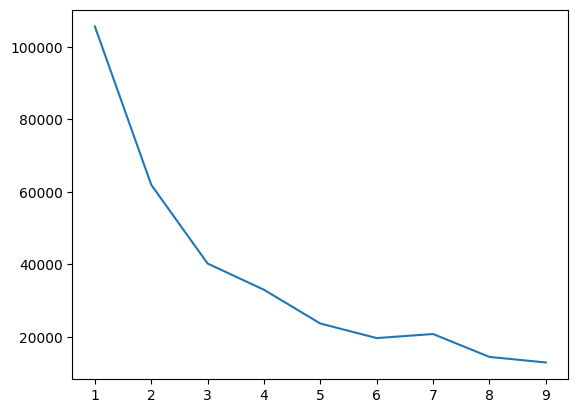

In [14]:
# create empty list
data = []

# loop over the list
for item in range(1,10):
    km = KMeans(n_clusters=item)
    km.fit_predict(winnersaf1)
    data.append(km.inertia_)

# have a look at the results, numbers have been ordered by the algorithm
print(data)
# plot chart
plt.plot(range(1,10), data)

In [15]:
# run KMeans and define number of clusters
km = KMeans(n_clusters = 4)

# fit prediction to clusters
clusters = km.fit_predict(data_array)

# print cluster groups
print(clusters)

[0 0 0 0 0 0 1 1 3 3 3 3 2 2 1 1 2 2 0 0 0 0 1 1 3 3 3 2 3 3 0 1 0 3 1 0 1
 0 1 2 2 3 3 0 2 2 3 1 0 0 3 2 1 3 1 3 0 0 0 2 3 3 3 0 2 1 2 3 3 2]


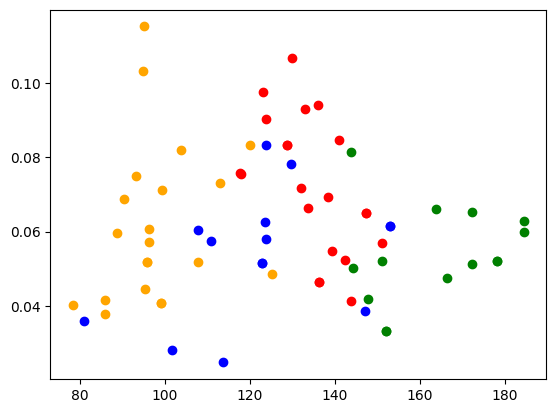

In [16]:
# plot
plt.scatter(data_array[clusters==0,0], data_array[clusters==0,1], color='red')
plt.scatter(data_array[clusters==1,0], data_array[clusters==1,1], color='green')
plt.scatter(data_array[clusters==2,0], data_array[clusters==2,1], color='blue')
plt.scatter(data_array[clusters==3,0], data_array[clusters==3,1], color='orange')
#plt.scatter(data_array[clusters==4,0], data_array[clusters==4,1], color='purple')

# Winners with themes

In [18]:
#only use this line of code once to create dummies
#winners = pd.get_dummies(df, columns=["theme"])


In [19]:
winners = winners[winners["key_scale"].notna()] # think winners with audio features.
winnersafthemes = winners[
    ['bpm','key','track_danceability',
     'var_PCP','max_PCP','dominant_pitch']
].join(
    winners.filter(like='theme_')
)

In [20]:
winnersafthemes.head

<bound method NDFrame.head of              bpm       key  track_danceability    var_PCP    max_PCP  \
18    118.026505  0.075462              1.0414  26.683755  20.531860   
25    117.753952  0.075712              0.8863  25.941887  18.198658   
39    136.088882  0.094057              1.0665  30.824251  25.855963   
61    129.936752  0.106839              1.1357   6.703276   9.101735   
76    128.758194  0.083314              0.9141  19.680767  19.601944   
...          ...       ...                 ...        ...        ...   
1360  163.886704  0.065960              0.9617  26.306166  17.856302   
1396  123.775368  0.057964              1.0243  67.519818  37.229030   
1447  120.074280  0.083372              1.0109  43.295899  31.094410   
1479   90.383034  0.068862              0.8506  21.922813  20.884644   
1532  129.624435  0.078070              1.1479  77.568900  44.050156   

      dominant_pitch  theme_Celebration & Party  theme_Empowerment  \
18               0.0               

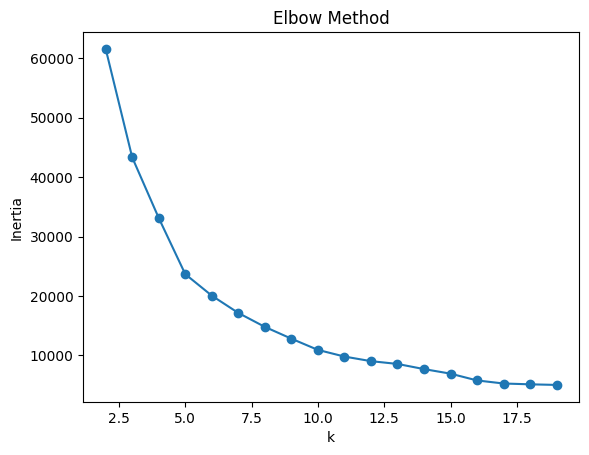

In [21]:
inertias = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=42)
    inertias.append(km.fit(winnersafthemes).inertia_)

plt.plot(range(2,20), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

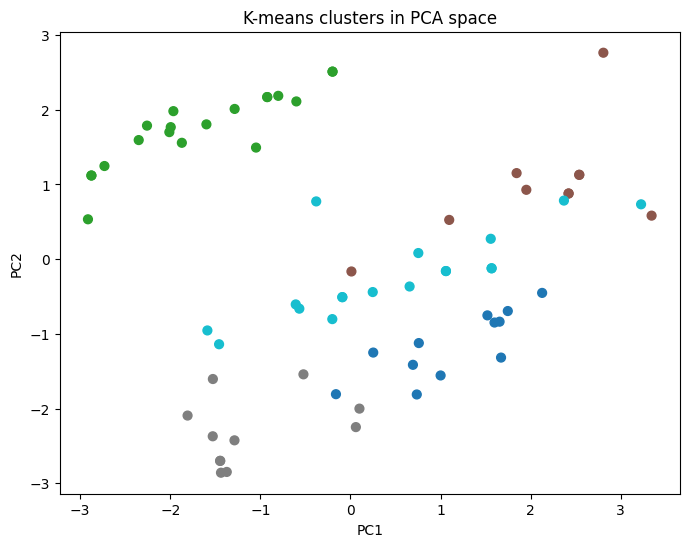

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(winnersafthemes)

pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(X_pca)

winnersafthemes["cluster"] = labels

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=40)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters in PCA space")
plt.show()


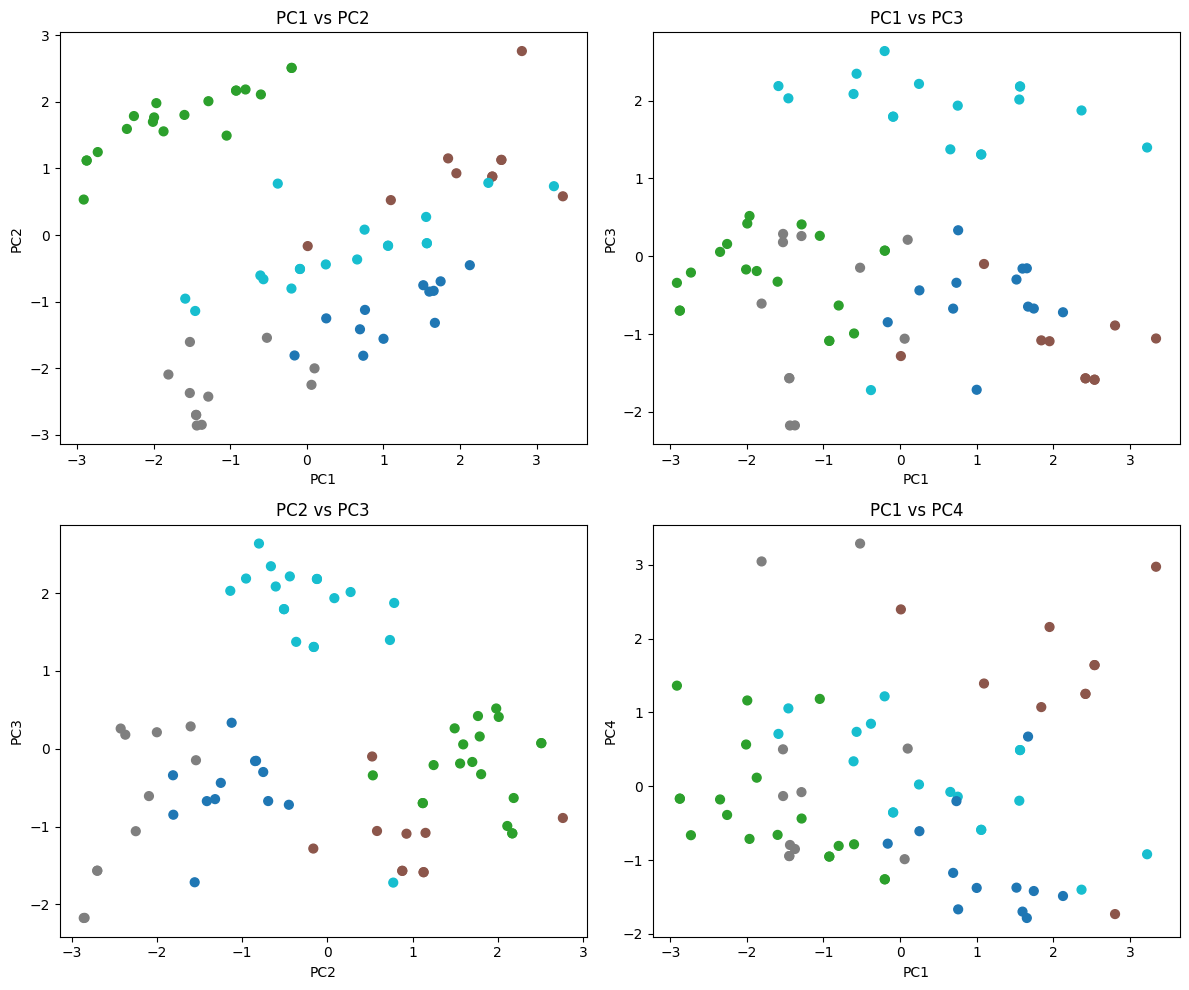

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

pairs = [(0,1), (0,2), (1,2), (0,3)]  # adjust based on PCA dimensionality
titles = ["PC1 vs PC2", "PC1 vs PC3", "PC2 vs PC3", "PC1 vs PC4"]

for ax, (i, j), title in zip(axes.ravel(), pairs, titles):
    ax.scatter(X_pca[:, i], X_pca[:, j], c=labels, cmap="tab10", s=40)
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [39]:
winnersafthemes.groupby("cluster").mean()

,bpm,key,track_danceability,var_PCP,max_PCP,dominant_pitch,theme_Celebration & Party,theme_Empowerment,theme_Heartbreak & Loss,theme_Hope & Unity,theme_Love & Romance,theme_Politics & Society
cluster,,,,,,,,,,,,
0,116.446206,0.054497,1.111483,55.426598,31.989932,2.166667,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
1,127.669345,0.067991,1.011068,35.790556,23.599483,3.263158,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
2,130.560976,0.055660,1.149460,82.234309,41.458862,2.900000,0.900000,0.000000,0.000000,0.1,0.000000,0.000000
3,147.626622,0.071646,1.065173,25.579254,18.071266,13.727273,0.181818,0.363636,0.363636,0.0,0.090909,0.000000
4,119.091620,0.057367,1.117617,46.708254,27.074378,0.277778,0.000000,0.000000,0.000000,0.0,0.944444,0.055556


In [40]:
silhouette_score(X_pca, labels)


0.3162304796653821

5 clusters - A PCA explained variance score of 0.32 (or 32%)   


In [41]:
cluster_map = {
    0: "Heartbreak", #breakup pop
    1: "Unifying InsPop",
    2: "Celebration",
    3: "High Energy",
    4: "Romance"
}
winnersafthemes["cluster_label"] = winnersafthemes["cluster"].map(cluster_map)

In [42]:
winnersafthemes.head

<bound method NDFrame.head of              bpm       key  track_danceability    var_PCP    max_PCP  \
18    118.026505  0.075462              1.0414  26.683755  20.531860   
25    117.753952  0.075712              0.8863  25.941887  18.198658   
39    136.088882  0.094057              1.0665  30.824251  25.855963   
61    129.936752  0.106839              1.1357   6.703276   9.101735   
76    128.758194  0.083314              0.9141  19.680767  19.601944   
...          ...       ...                 ...        ...        ...   
1360  163.886704  0.065960              0.9617  26.306166  17.856302   
1396  123.775368  0.057964              1.0243  67.519818  37.229030   
1447  120.074280  0.083372              1.0109  43.295899  31.094410   
1479   90.383034  0.068862              0.8506  21.922813  20.884644   
1532  129.624435  0.078070              1.1479  77.568900  44.050156   

      dominant_pitch  theme_Celebration & Party  theme_Empowerment  \
18               0.0               

In [43]:
df["cluster"] = winnersafthemes["cluster"]

In [44]:
df["cluster_label"] = winnersafthemes["cluster_label"]

In [45]:
df.columns

Index(['year', 'to_country_id', 'to_country', 'artist', 'song',
       'place_contest', 'sf_num', 'running_final', 'running_sf', 'place_final',
       'points_final', 'place_sf', 'points_sf', 'points_tele_final',
       'points_jury_final', 'points_tele_sf', 'points_jury_sf', 'composers',
       'lyricists', 'lyrics', 'youtube_url', 'spotify_track_id',
       'spotify_track_name', 'spotify_album_name',
       'spotify_album_release_date', 'spotify_track_popularity', 'spotify_url',
       'language', 'lyrics_en', 'processed_lyrics', 'winner', 'top3',
       'Danceability', 'bpm', 'rhythm_strength', 'key', 'scale_vector',
       'track', 'track_danceability', 'key_scale', 'var_PCP', 'max_PCP',
       'dominant_pitch', 'dominant_pitch_class', 'theme_Celebration & Party',
       'theme_Empowerment', 'theme_Heartbreak & Loss', 'theme_Hope & Unity',
       'theme_Love & Romance', 'theme_Politics & Society', 'cluster',
       'cluster_label'],
      dtype='object')

In [46]:
df.to_csv("merged_dataset_with_clusters.csv", index=False)

In [47]:
df.sort_values('cluster_label')


,year,to_country_id,to_country,artist,song,place_contest,sf_num,running_final,running_sf,place_final,...,dominant_pitch,dominant_pitch_class,theme_Celebration & Party,theme_Empowerment,theme_Heartbreak & Loss,theme_Hope & Unity,theme_Love & Romance,theme_Politics & Society,cluster,cluster_label
1532,2018,il,Israel,Netta Barzilai,Toy,1.0,1.0,22.0,7.0,1.0,...,0.0,C,True,False,False,False,False,False,2.0,Celebration
190,1967,gb,United Kingdom,Sandie Shaw,Puppet On A String,1.0,NaN,11.0,NaN,1.0,...,9.0,A,True,False,False,False,False,False,2.0,Celebration
189,1967,gb,United Kingdom,Sandie Shaw,Puppet On A String,1.0,NaN,11.0,NaN,1.0,...,9.0,A,True,False,False,False,False,False,2.0,Celebration
611,1989,yu,Yugoslavia,Riva,Rock Me,1.0,NaN,22.0,NaN,1.0,...,0.0,C,True,False,False,False,False,False,2.0,Celebration
153,1965,lu,Luxembourg,France Gall,"Poupée De Cire, Poupée De Son",1.0,NaN,15.0,NaN,1.0,...,0.0,C,True,False,False,False,False,False,2.0,Celebration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2023,lv,Latvia,Sudden Lights,Aijā,NaN,1.0,NaN,4.0,NaN,...,NaN,NaN,True,False,False,False,False,False,NaN,NaN
1763,2023,ie,Ireland,Wild Youth,We Are One,NaN,1.0,NaN,6.0,NaN,...,NaN,NaN,False,False,False,False,True,False,NaN,NaN
1764,2023,nl,Netherlands,Mia Nicolai & Dion Cooper,Burning Daylight,NaN,1.0,NaN,14.0,NaN,...,NaN,NaN,False,False,False,False,True,False,NaN,NaN
1765,2023,az,Azerbaijan,TuralTuranX,Tell Me More,NaN,1.0,NaN,12.0,NaN,...,NaN,NaN,False,False,True,False,False,False,NaN,NaN


In [48]:
table = (
    df.groupby('cluster_label')['dominant_pitch_class']
      .value_counts()
      .unstack(fill_value=0)
)

table

dominant_pitch_class,C,A,D,C#,G,A#,B,D#,F
cluster_label,,,,,,,,,
Celebration,6,3,1,0,0,0,0,0,0
Heartbreak,7,0,3,1,1,0,0,0,0
High Energy,3,1,0,0,0,3,2,2,0
Romance,15,0,2,1,0,0,0,0,0
Unifying InsPop,11,1,6,0,0,0,0,0,1


Skipping cluster nan (not enough points)


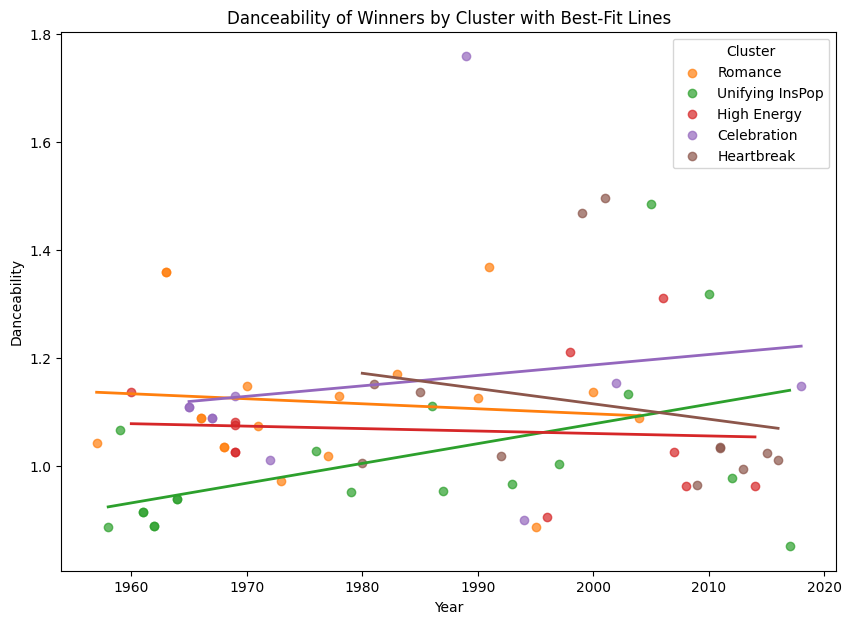

In [51]:
plt.figure(figsize=(10,7))

clusters = df['cluster_label'].unique()
cmap = plt.get_cmap('tab10')

for i, cl in enumerate(clusters):
    sub = df[df['cluster_label'] == cl]

    # Skip clusters with no data
    if len(sub) < 2:
        print(f"Skipping cluster {cl} (not enough points)")
        continue

    plt.scatter(
        sub['year'],
        sub['track_danceability'],
        color=cmap(i),
        alpha=0.7,
        label=f"{cl}"
    )

    # Fit line
    m, b = np.polyfit(sub['year'], sub['track_danceability'], 1)
    x_vals = np.linspace(sub['year'].min(), sub['year'].max(), 200)
    y_vals = m * x_vals + b

    plt.plot(x_vals, y_vals, color=cmap(i), linewidth=2)

plt.xlabel("Year")
plt.ylabel("Danceability")
plt.title("Danceability of Winners by Cluster with Best‑Fit Lines")
plt.legend(title="Cluster")
plt.show()

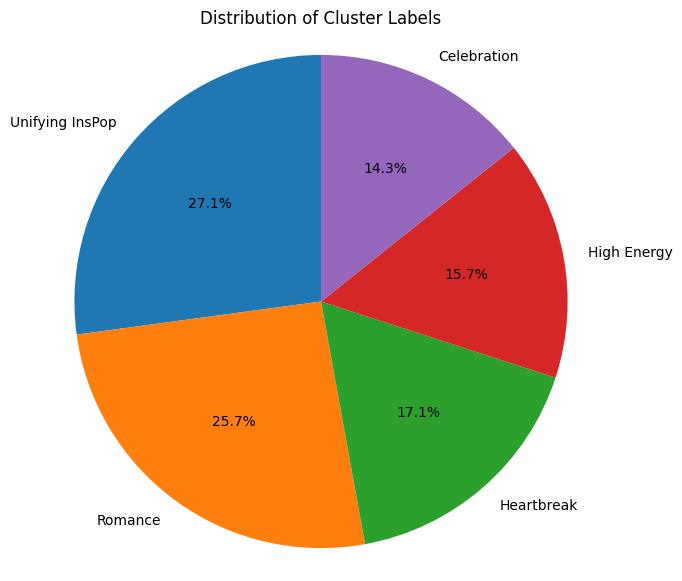

In [52]:
counts = df['cluster_label'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of Cluster Labels')
plt.axis('equal')
plt.show()


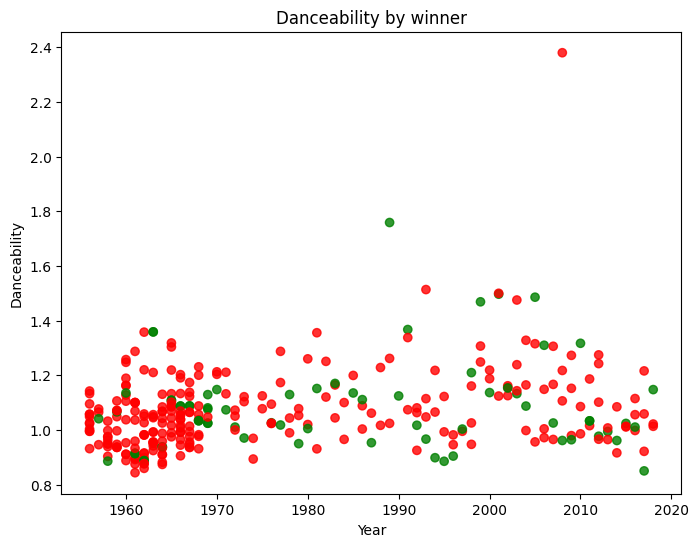

In [53]:
plt.figure(figsize=(8,6))

colors = df['winner'].map({True: 'green', False: 'red'})

plt.scatter(
    df['year'],
    df['track_danceability'],
    c=colors,          
    alpha=0.8
)

plt.xlabel("Year")
plt.ylabel("Danceability")
plt.title("Danceability by winner")
plt.show()


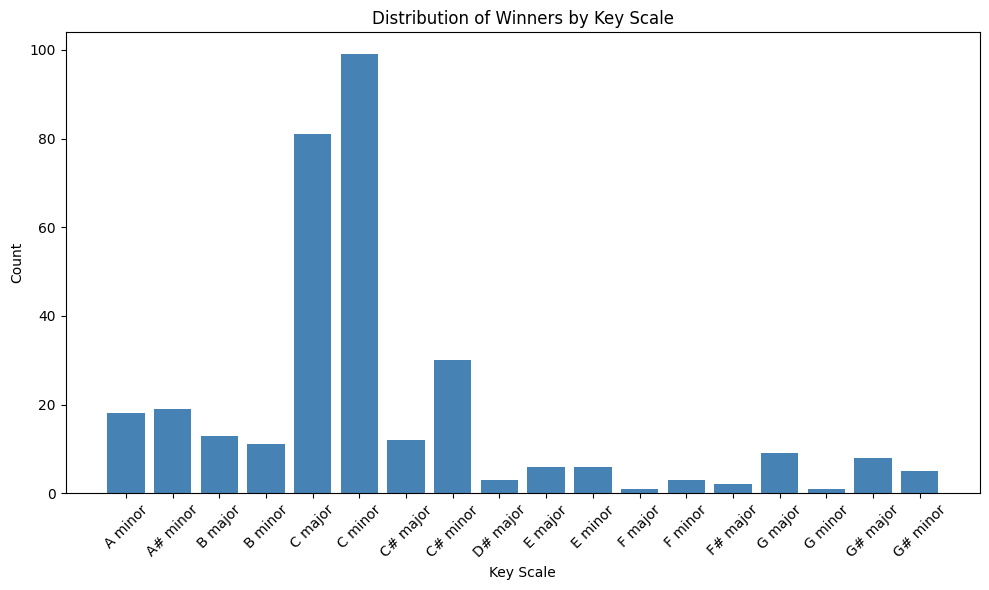

In [54]:
counts = df['key_scale'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values, color='steelblue')

plt.xlabel("Key Scale")
plt.ylabel("Count")
plt.title("Distribution of Winners by Key Scale")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
agg = (
    df.groupby('language')
      .agg(
          wins = ('winner', lambda x: (x == True).sum()),
          losses = ('winner', lambda x: (x == False).sum())
      )
      .sort_values('wins', ascending=False)
      .reset_index()
)
agg

,language,wins,losses
0,en,35,752
1,fr,17,169
2,es,4,61
3,it,4,70
4,hr,3,83
5,de,3,91
6,nl,3,54
7,da,2,28
8,no,2,44
9,sv,2,36


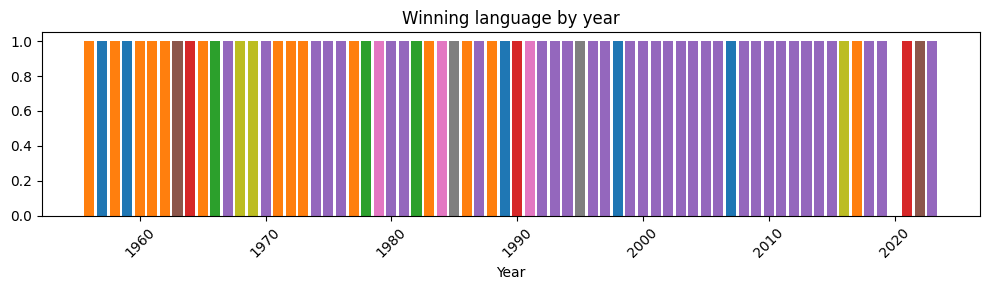

In [56]:
plt.figure(figsize=(10,3))

for lang in df['language'].unique():
    subset = df[df['language'] == lang]
    plt.bar(
        subset['year'],
        subset['winner'].astype(int),
        label=lang
    )

plt.xlabel("Year")
#plt.ylabel("Winner")
plt.title("Winning language by year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Kaggle Dataset
https://www.kaggle.com/datasets/diamondsnake/eurovision-song-contest-data?resource=download 

In [57]:
songs = pd.read_csv("kaggle_song_data.csv", encoding='latin1')
print(songs.columns)

Index(['year', 'semi_final', 'semi_draw_position', 'final_draw_position',
       'country', 'artist_name', 'song_name', 'language', 'style',
       'direct_qualifier_10', 'gender', 'main_singers', 'age', 'selection',
       'key', 'BPM', 'energy', 'danceability', 'happiness', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'speechiness',
       'release_date', 'key_change_10', 'backing_dancers', 'backing_singers',
       'backing_instruments', 'instrument_10', 'qualified_10',
       'final_televote_points', 'final_jury_points', 'final_televote_votes',
       'final_jury_votes', 'final_place', 'final_total_points', 'semi_place',
       'semi_televote_points', 'semi_jury_points', 'semi_total_points',
       'favourite_10', 'race', 'host_10'],
      dtype='object')


In [58]:
songs['final_place'].unique()

array([ 5., nan, 24., 23., 13., 20.,  3., 18.,  1., 10.,  2., 14.,  8.,
        7., 12., 19., 21., 15., 22., 11.,  9., 16., 17.,  4.,  6., 26.,
       25., 27.])

In [59]:
songs['danceability'] = pd.to_numeric(songs['danceability'], errors='coerce')

In [60]:
songs['final_place'] = songs['final_place'].astype('Int64')
songs['winner'] = songs['final_place'] == 1
songs = songs.dropna(subset=['winner'])

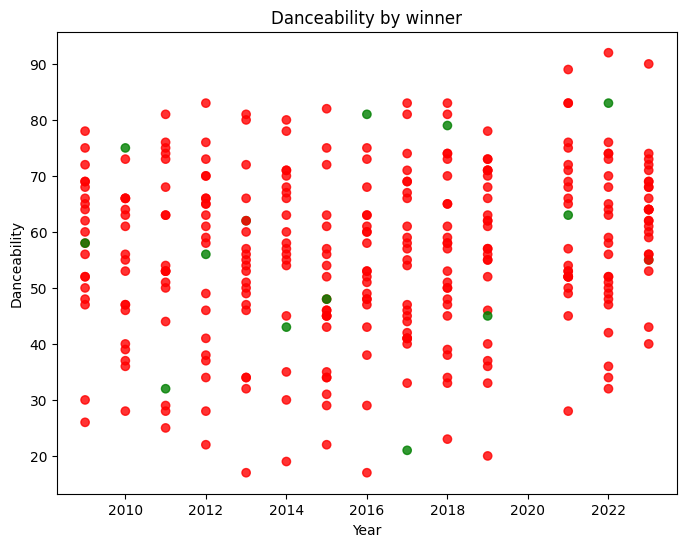

In [61]:
plt.figure(figsize=(8,6))

colors = songs['winner'].map({True: 'green', False: 'red'})

plt.scatter(
    songs['year'],
    songs['danceability'],
    c=colors,          
    alpha=0.8
)

plt.xlabel("Year")
plt.ylabel("Danceability")
#plt.yticks(plt.yticks()[0][::5])

plt.title("Danceability by winner")
plt.show()

In [62]:
agg = (
    songs.groupby('language')
      .agg(
          wins = ('winner', lambda x: (x == True).sum()),
          losses = ('winner', lambda x: (x == False).sum())
      )
      .sort_values('wins', ascending=False)
      .reset_index()
)
agg

,language,wins,losses
0,English,10,231
1,"English, Crimean Tatar",1,0
2,Italian,1,9
3,Portuguese,1,4
4,Ukrainian,1,1
5,Bosnian,0,2
6,Breton,0,1
7,Dutch,0,1
8,Belarusian,0,1
9,Croatian,0,2
